# Sample Code for HW5
# User-based and Item-based CF (Pearson Correlation Coefficient)
## Convert the rating file into a user-item matrix

In [1]:
import numpy as np
import pandas as pd

ratingfile = 'ratings.data'
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(ratingfile, sep='\t', names=header)

n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

user_item_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    user_item_matrix[line[1] - 1, line[2] - 1] = line[3]

Number of users = 943 | Number of movies = 1682


## Pre-compute the user-user similarity matrix using pearson correlation
The user-user similarity matrix represents the similiarty between each user-user pair. **It is important to note that this computation may take around 10 minutes or more to complete.**

In [2]:
import scipy.stats
import scipy.spatial
import math
from math import sqrt

user_similarity_pearson = np.zeros((n_users, n_users))

# compute the similarities in the upper triangle part
for user1 in range(n_users):
    for user2 in range(n_users):
        if(user1 <= user2):
            break
        elif np.count_nonzero(user_item_matrix[user1]) and np.count_nonzero(user_item_matrix[user2]):
            try:
                if not math.isnan(scipy.stats.pearsonr(user_item_matrix[user1], user_item_matrix[user2])[0]):
                    user_similarity_pearson[user1][user2] = scipy.stats.pearsonr(user_item_matrix[user1], user_item_matrix[user2])[0]
                else:
                    user_similarity_pearson[user1][user2] = 0
            except:
                user_similarity_pearson[user1][user2] = 0
                
# complete all entries by  add the transposed similarity matrix to our
# previously computed values                
user_similarity_pearson = user_similarity_pearson + user_similarity_pearson.T

## Pre-compute the item-item similarity matrix using pearson correlation
The item-item similarity matrix represents the similiarty between each item-item pair. **It is important to note that this computation may take around 10 minutes or more to complete.**

In [3]:
item_similarity_pearson = np.zeros((n_items, n_items))
data = user_item_matrix.T.copy()
# compute the similarities in the upper triangle part
for item1 in range(n_items):
    for item2 in range(n_items):
        if item1 <= item2:
            break
        elif np.count_nonzero(data[item1]) and np.count_nonzero(data[item2]):
            try:
                if not math.isnan(scipy.stats.pearsonr(data[item1], data[item2])[0]):
                    item_similarity_pearson[item1][item2] = scipy.stats.pearsonr(data[item1], data[item2])[0]
                else:
                    item_similarity_pearson[item1][item2] = 0
            except:
                item_similarity_pearson[item1][item2] = 0
                
# complete all entries by  add the transposed similarity matrix to our
# previously computed values                
item_similarity_pearson = item_similarity_pearson + item_similarity_pearson.T

## Split the user-item matrix set into training set and testing set

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# split the data set into training set and testing set
train_data, test_data = train_test_split(df, test_size=0.25)

## Rating predict function based on the the user-user similarity

In [17]:
def userbased_predict_rmse(train, test, user_similarity, n_users, n_items, k):
    
    print("Compute User-based CF RMSE .......", "K =", k)
    # transfer the train set of ratings to user-item matrix
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)

    train_matrix = np.zeros((n_users, n_items))
    for line in train.itertuples():
        train_matrix[int(line[1]) - 1, int(line[2]) - 1] = line[3]

    true_rate = []
    pred_rate = []

    for line in test.itertuples():
        user = int(line[1])
        item = int(line[2])
        true_rate.append(line[3])

        item_pred = 3.0

        if np.count_nonzero(train_matrix[user-1]):
            sim_pearson = user_similarity[user - 1]
            # sort the similarities in descending order, find the k similar items which has the largest similarities
            sortedindex = np.argsort(-sim_pearson)
            normal_pearson = 0
            dot = 0
            for i in range(k):
                ind = sortedindex[i]
                # normalize the similarity for the rated items
                normal_pearson += np.absolute(sim_pearson[ind])
                # similarity multiply the ratings
                dot += sim_pearson[ind] * train_matrix[ind][item-1]

            if normal_pearson > 0:
                item_pred = dot / normal_pearson

        if item_pred < 0:
            item_pred = 0

        if item_pred > 5:
            item_pred = 5

        pred_rate.append(item_pred)

    rmse= sqrt(mean_squared_error(true_rate, pred_rate))

    return rmse,pred_rate

## Rating predict function based on the the item-item similarity

In [18]:
def itembased_predict_rmse(train, test, item_similarity, n_users, n_items, k):
    print("Compute Item-based CF RMSE .......", "K =", k)
    # transfer the train set of ratings to user-item matrix
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    
    train_matrix = np.zeros((n_users, n_items))
    for line in train.itertuples():
        train_matrix[line[1] - 1, line[2] - 1] = line[3]

    true_rate = []
    pred_rate = []

    for line in test.itertuples():
        user = line[1]
        item = line[2]
        true_rate.append(line[3])

        item_pred = 3.0

        if np.count_nonzero(train_matrix[:, item - 1]):
            sim_pearson = item_similarity[item - 1]
            # sort the similarities, find the k similar items which has the laest the similarities
            sortedindex = np.argsort(-sim_pearson)
            normal_pearson = 0
            dot = 0
            for i in range(k):
                ind = sortedindex[i]
                # normalize the similarity for the rated items
                normal_pearson += np.absolute(sim_pearson[ind])
                # similarity multiply the ratings
                dot += sim_pearson[ind] * train_matrix[user - 1][ind]

            if normal_pearson > 0:
                item_pred = dot / normal_pearson

        if item_pred < 0:
            item_pred = 0

        if item_pred > 5:
            item_pred = 5

        pred_rate.append(item_pred)

    rmse= sqrt(mean_squared_error(true_rate, pred_rate))

    return rmse,pred_rate

## Predict the ratings for testing set, and compute the RMSE

In [19]:
rmse_user = []
rmse_item = []

for i in range(3,10):
    k =  i
    # user-based CF
    rmse_u, pred_rate_u = userbased_predict_rmse(train_data, test_data, user_similarity_pearson, n_users, n_items, k)
    rmse_user.append(rmse_u)
    # item-based CF
    rmse_i,pred_rate_i = itembased_predict_rmse(train_data, test_data, item_similarity_pearson, n_users, n_items, k)
    rmse_item.append(rmse_i) 

Compute User-based CF RMSE ....... K = 3
Compute Item-based CF RMSE ....... K = 3
Compute User-based CF RMSE ....... K = 4
Compute Item-based CF RMSE ....... K = 4
Compute User-based CF RMSE ....... K = 5
Compute Item-based CF RMSE ....... K = 5
Compute User-based CF RMSE ....... K = 6
Compute Item-based CF RMSE ....... K = 6
Compute User-based CF RMSE ....... K = 7
Compute Item-based CF RMSE ....... K = 7
Compute User-based CF RMSE ....... K = 8
Compute Item-based CF RMSE ....... K = 8
Compute User-based CF RMSE ....... K = 9
Compute Item-based CF RMSE ....... K = 9


In [20]:
for i in range(1,11):
    k = 10 * i
    # user-based CF
    rmse_u,pred_rate_u = userbased_predict_rmse(train_data, test_data,user_similarity_pearson, n_users, n_items, k)
    rmse_user.append(rmse_u)
    # item-based CF
    rmse_i,pred_rate_i = itembased_predict_rmse(train_data, test_data,item_similarity_pearson, n_users, n_items, k)
    rmse_item.append(rmse_i)    

Compute User-based CF RMSE ....... K = 10
Compute Item-based CF RMSE ....... K = 10
Compute User-based CF RMSE ....... K = 20
Compute Item-based CF RMSE ....... K = 20
Compute User-based CF RMSE ....... K = 30
Compute Item-based CF RMSE ....... K = 30
Compute User-based CF RMSE ....... K = 40
Compute Item-based CF RMSE ....... K = 40
Compute User-based CF RMSE ....... K = 50
Compute Item-based CF RMSE ....... K = 50
Compute User-based CF RMSE ....... K = 60
Compute Item-based CF RMSE ....... K = 60
Compute User-based CF RMSE ....... K = 70
Compute Item-based CF RMSE ....... K = 70
Compute User-based CF RMSE ....... K = 80
Compute Item-based CF RMSE ....... K = 80
Compute User-based CF RMSE ....... K = 90
Compute Item-based CF RMSE ....... K = 90
Compute User-based CF RMSE ....... K = 100
Compute Item-based CF RMSE ....... K = 100


In [21]:
print("User-based RMSE: ", rmse_user)
print("Item-based RMSE: ", rmse_item)
m = np.zeros((17, 2))
j = 0
for i in range(17):
    m[i][j] = rmse_user[i]
j = 1
for i in range(17):
    m[i][j] = rmse_item[i]
print(m)

user based rmse:  [2.521653035435374, 2.4846188917322984, 2.4641312487805656, 2.454661012907798, 2.45056085686577, 2.4451163323353553, 2.4412364109819746, 2.4436046833474276, 2.456774205494055, 2.481025755536663, 2.504561370883164, 2.526247102250885, 2.5450467561174874, 2.5619533351417516, 2.5782029015869967, 2.5931034761038645, 2.607515953679428]
item based rmse:  [2.4491157295565396, 2.4185479141412465, 2.4006258278960404, 2.3947929078986823, 2.3911009448065292, 2.3886989718263854, 2.3913404627687385, 2.3928666615943173, 2.4288511858159816, 2.4670724946188263, 2.499639379877057, 2.530374230207508, 2.5573967510401134, 2.582538806466039, 2.603892926060121, 2.6229720625466153, 2.641240707918446]
[[2.52165304 2.44911573]
 [2.48461889 2.41854791]
 [2.46413125 2.40062583]
 [2.45466101 2.39479291]
 [2.45056086 2.39110094]
 [2.44511633 2.38869897]
 [2.44123641 2.39134046]
 [2.44360468 2.39286666]
 [2.45677421 2.42885119]
 [2.48102576 2.46707249]
 [2.50456137 2.49963938]
 [2.5262471  2.530374

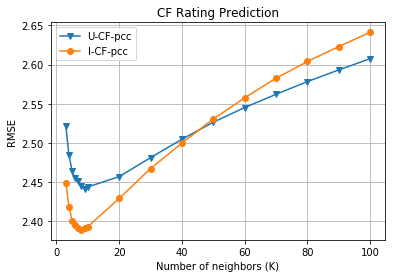

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

idx = [3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
plt.plot(idx, rmse_user, marker='v', label='U-CF-pcc')
plt.plot(idx, rmse_item, marker='o', label='I-CF-pcc')

plt.title('CF Rating Prediction')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.grid()
plt.show()